In [5]:
#pip install seaborn

In [6]:
#pip install scikit-learn

In [7]:
from pymongo import MongoClient
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
import string
import nltk
import re
#from tensorflow.keras import layers
#from tensorflow import keras
#import tensorflow as tf

from sklearn.model_selection import train_test_split

from ast import literal_eval

import matplotlib.pyplot as plt
import numpy as np

#### Connection of MongoDB

In [8]:
client = MongoClient("mongodb://localhost:27017/")  #name of the connection string 
db = client["DBLP"]             #name of the Database

#collection_dblp = db["citation_data"]    #Name of the item Name
collection_dblp = db["new_data"]
collection_arix = db["Arix"]  
# Fetch all data
cursor = collection_dblp.find()

#cursor1 = collection_arix.find()

In [9]:
df = pd.DataFrame(list(cursor))
#df=pd.read_csv('final_dataset.csv')

In [10]:
df=df[['id','title','abstract','authors','n_citation','year','references','venue']]

In [11]:
df = df.infer_objects()
df.dtypes

id            object
title         object
abstract      object
authors       object
n_citation     int64
year           int64
references    object
venue         object
dtype: object

In [12]:
df.shape

(1000000, 8)

In [13]:
df_null=df.copy()

In [14]:
df_null.isnull().sum()

id                 0
title              0
abstract      172467
authors            2
n_citation         0
year               0
references    124417
venue         177755
dtype: int64

In [15]:
df_null.dropna(inplace=True)

In [16]:
df_null.isnull().sum()

id            0
title         0
abstract      0
authors       0
n_citation    0
year          0
references    0
venue         0
dtype: int64

In [17]:
df_null.shape

(693622, 8)

In [18]:
df_null.drop_duplicates(subset=['id'], keep='first', inplace=True)
df_null.reset_index(drop= True,inplace = True)

In [19]:
df_id=df_null[['id','title','abstract','n_citation','references']]
df_references=df_null[['id','references']]

In [20]:
df_id['original_title']=df_id['title']

C:\Users\user\AppData\Local\Temp\ipykernel_11164\3895716370.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_id['original_title']=df_id['title']


In [21]:
df_id=df_id.head(500000)

In [22]:
df_id1=df_id.copy()

In [23]:
df_id.head()

,id,title,abstract,n_citation,references,original_title
0,4ab3735c-80f1-472d-b953-fa0557fed28b,A new approach of 3D watermarking based on ima...,"In this paper, a robust 3D triangular mesh wat...",50,"['09cb2d7d-47d1-4a85-bfe5-faa8221e644b', '10aa...",A new approach of 3D watermarking based on ima...
1,4ab39729-af77-46f7-a662-16984fb9c1db,Attractor neural networks with activity-depend...,We studied an autoassociative neural network w...,50,"['4017c9d2-9845-4ad2-ad5b-ba65523727c5', 'b118...",Attractor neural networks with activity-depend...
2,4ab3a4cf-1d96-4ce5-ab6f-b3e19fc260de,A characterization of balanced episturmian seq...,It is well-known that Sturmian sequences are t...,50,"['1c655ee2-067d-4bc4-b8cc-bc779e9a7f10', '2e4e...",A characterization of balanced episturmian seq...
3,4ab3a98c-3620-47ec-b578-884ecf4a6206,Exploring the space of a human action,One of the fundamental challenges of recognizi...,221,"['056116c1-9e7a-4f9b-a918-44eb199e67d6', '05ac...",Exploring the space of a human action
4,4ab3b585-82b4-4207-91dd-b6bce7e27c4e,Generalized upper bounds on the minimum distan...,This paper generalizes previous optimal upper ...,0,"['01a765b8-0cb3-495c-996f-29c36756b435', '5dbc...",Generalized upper bounds on the minimum distan...


## Preprocessing Steps for Natural Language Processing (NLP)
### Text Cleaning
#### I. Converting to lowercase

In [24]:
df_id = df_id.applymap(lambda x: x.lower() if isinstance(x, str) else x)

C:\Users\user\AppData\Local\Temp\ipykernel_11164\461851235.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_id = df_id.applymap(lambda x: x.lower() if isinstance(x, str) else x)


### II. Removing URLs

In [25]:

url_pattern = re.compile(r'https?://\S+')

# Define a function to remove URLs from text
def remove_urls(text):
    if isinstance(text, list):
        # Join list into a single string
        text = ' '.join(text)
    return url_pattern.sub('', text)

# Apply the function to the 'title' and 'abstract' columns and create new columns 'clean_title' and 'clean_abstract'
df_id['title'] = df_id['title'].apply(remove_urls)
df_id['abstract'] = df_id['abstract'].apply(remove_urls)

### III. Removing remove non-word and non-whitespace characters

In [26]:
df_id['title'] = df_id['title'].replace(to_replace=r'[^\w\s\b\d+]', value='', regex=True)
df_id['abstract'] = df_id['abstract'].replace(to_replace=r'[^\w\s\b\d+\b]', value='', regex=True)

### IV. Removing digits

In [27]:
df_id['title'] = df_id['title'].replace(to_replace=r'\d', value='', regex=True)
df_id['abstract'] = df_id['abstract'].replace(to_replace=r'\d', value='', regex=True)

## 2. Tokenization
#### Tokenization is the process of breaking down large blocks of text such as paragraphs and sentences into smaller, more manageable units.

In [28]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [29]:
df_id['title'] = df_id['title'].apply(word_tokenize)

In [30]:
df_id['abstract'] = df_id['abstract'].apply(word_tokenize)

## 3. Stopword Removal
#### Stopwords refer to the most commonly occurring words in any natural language.

In [31]:
stop_words = set(stopwords.words('english'))
df_id['title'] = df_id['title'].apply(lambda x: [word for word in x if word not in stop_words])
df_id['abstract'] = df_id['abstract'].apply(lambda x: [word for word in x if word not in stop_words])

## 4. Stemming/Lemmatization

In [32]:
# Initialize the Porter Stemmer
stemmer = PorterStemmer()

# Define a function to perform stemming on the 'text' column
def stem_words(words):
    return [stemmer.stem(word) for word in words]
# Apply the function to the 'text' column and create a new column 'stemmed_text'
df_id['title'] = df_id['title'].apply(stem_words)
df_id['abstract'] = df_id['abstract'].apply(stem_words)

In [33]:
df_id.head()

,id,title,abstract,n_citation,references,original_title
0,4ab3735c-80f1-472d-b953-fa0557fed28b,"[new, approach, watermark, base, imag, segment]","[paper, robust, triangular, mesh, watermark, a...",50,"['09cb2d7d-47d1-4a85-bfe5-faa8221e644b', '10aa...",a new approach of 3d watermarking based on ima...
1,4ab39729-af77-46f7-a662-16984fb9c1db,"[attractor, neural, network, activitydepend, s...","[studi, autoassoci, neural, network, dynam, sy...",50,"['4017c9d2-9845-4ad2-ad5b-ba65523727c5', 'b118...",attractor neural networks with activity-depend...
2,4ab3a4cf-1d96-4ce5-ab6f-b3e19fc260de,"[character, balanc, episturmian, sequenc]","[wellknown, sturmian, sequenc, non, ultim, per...",50,"['1c655ee2-067d-4bc4-b8cc-bc779e9a7f10', '2e4e...",a characterization of balanced episturmian seq...
3,4ab3a98c-3620-47ec-b578-884ecf4a6206,"[explor, space, human, action]","[one, fundament, challeng, recogn, action, acc...",221,"['056116c1-9e7a-4f9b-a918-44eb199e67d6', '05ac...",exploring the space of a human action
4,4ab3b585-82b4-4207-91dd-b6bce7e27c4e,"[gener, upper, bound, minimum, distanc, psk, b...","[paper, gener, previou, optim, upper, bound, m...",0,"['01a765b8-0cb3-495c-996f-29c36756b435', '5dbc...",generalized upper bounds on the minimum distan...


# 1. Loading Preprocessing Data

In [34]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import cosine
import chromadb
from chromadb.config import Settings

# Ensure the 'title' and 'abstract' columns contain strings
df_id['title'] = df_id['title'].astype(str)
df_id['abstract'] = df_id['abstract'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))

# Concatenate title and abstract
df_id['combined_text'] = df_id['title'] + " " + df_id['abstract']

# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=768)  # Adjust the max_features based on your needs

# Fit and transform the combined text column
df_id['combined_embeddings'] = list(vectorizer.fit_transform(df_id['combined_text']).toarray())

# Ensure IDs are strings
df_id['id'] = df_id['id'].astype(str)



In [35]:
# Connect to Chroma and create a collection
client = chromadb.Client(Settings())
combined_collection = client.create_collection("combined_embeddings")

# Convert numpy arrays to lists
combined_embeddings = [emb.tolist() for emb in df_id["combined_embeddings"]]

# Split data into smaller batches
def split_into_batches(data, batch_size):
    for i in range(0, len(data), batch_size):
        yield data[i:i + batch_size]

# Add embeddings to the collection in batches
batch_size = 150  # Set to the maximum allowed batch size
ids_batches = list(split_into_batches(df_id["id"].tolist(), batch_size))
combined_embeddings_batches = list(split_into_batches(combined_embeddings, batch_size))
combined_metadatas_batches = list(split_into_batches(df_id[["title", "abstract"]].to_dict(orient="records"), batch_size))

for ids_batch, combined_embeddings_batch, combined_metadatas_batch in zip(ids_batches, combined_embeddings_batches, combined_metadatas_batches):
    combined_collection.add(ids=ids_batch, embeddings=combined_embeddings_batch, metadatas=combined_metadatas_batch)


# Jacaard_score

In [60]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import jaccard_score
import numpy as np

# Function to find the ID and title based on an exact title match
def find_exact_title_match(title_query, df_id1):
    for idx, row in df_id1.iterrows():
        if row['title'].strip().lower() == title_query.strip().lower():
            return row['id'], row['title']
    return None, None  # Return None if no exact match is found

# Function to compute Jaccard similarity
def jaccard_similarity(query, document):
    query_set = set(query.split())
    document_set = set(document.split())
    intersection = query_set.intersection(document_set)
    union = query_set.union(document_set)
    if not union:  # Avoid division by zero
        return 0.0
    return len(intersection) / len(union)

# Function to find and rerank similar texts using Jaccard similarity
def find_and_rerank_similar_texts(user_query, df_id, top_n=5):
    similarities = []
    for idx, row in df_id.iterrows():
        document = row['title'] + " " + row['abstract']  # Combine title and abstract
        sim_score = jaccard_similarity(user_query, document)
        similarities.append((row['id'], row['title'], sim_score))
    
    # Sort by Jaccard similarity in descending order
    similarities.sort(key=lambda x: x[2], reverse=True)
    return similarities[:top_n]

# Function to recommend papers based on user input using Jaccard similarity
def recommend_articles(user_query, df_id, top_n=5):
    # Find and rerank similar texts using Jaccard similarity
    similar_texts = find_and_rerank_similar_texts(user_query, df_id, top_n)
    
    recommended_articles = []
    for id, title, score in similar_texts:
        recommended_articles.append((id, title, score))
    
    return recommended_articles

# Example usage
user_queries = [
    "Distinctive Image Features from Scale-Invariant Keypoints"
]

for user_query in user_queries:
    print(f"User Input Exact Title: '{user_query}':")
    
    # Check for exact title match in df_id1
    exact_match_id, exact_match_title = find_exact_title_match(user_query, df_id1)
    
    if exact_match_id is not None:
        print(f"ID: {exact_match_id}, Title: {exact_match_title}")
        # stored_variable = (exact_match_id, exact_match_title)  # Store in variable
        # print(f"Stored Variable: {stored_variable}")
    else:
        print(f"No exact title match found in df_id1 for '{user_query}'")
    
    # Proceed with recommendation if no exact match found
    recommended_articles = recommend_articles(user_query, df_id, top_n=5)
    for rank, (id, title, score) in enumerate(recommended_articles, 1):
        print(f"Rank {rank}: ID: {id}, Title: {title}, Jaccard Similarity Score: {score:.4f}")


User Input Exact Title: 'Distinctive Image Features from Scale-Invariant Keypoints':
ID: b944f77f-113b-4a02-ae5e-d4a124b8fd5b, Title: Distinctive Image Features from Scale-Invariant Keypoints
Rank 1: ID: 6bdc6b1f-57a5-4d6b-9d5a-ff73e1ccb86b, Title: ['comput', 'simpl', 'path', 'among', 'obstacl'], Jaccard Similarity Score: 0.0161
Rank 2: ID: 6f5cd738-5c98-49b2-abb3-c79b0166e60c, Title: ['effici', 'implement', 'reinforc', 'learn', 'base', 'rout', 'real', 'wsn', 'hardwar'], Jaccard Similarity Score: 0.0081
Rank 3: ID: 4ab3735c-80f1-472d-b953-fa0557fed28b, Title: ['new', 'approach', 'watermark', 'base', 'imag', 'segment'], Jaccard Similarity Score: 0.0000
Rank 4: ID: 4ab39729-af77-46f7-a662-16984fb9c1db, Title: ['attractor', 'neural', 'network', 'activitydepend', 'synaps', 'role', 'synapt', 'facilit'], Jaccard Similarity Score: 0.0000
Rank 5: ID: 4ab3a4cf-1d96-4ce5-ab6f-b3e19fc260de, Title: ['character', 'balanc', 'episturmian', 'sequenc'], Jaccard Similarity Score: 0.0000


Number of Recommendations: 25
  Accuracy: 28.00%
  Precision: 28.00%
  Recall: 100.00%
  F1-Score: 43.75%
  True Negatives: 0
  False Positives: 18
  False Negatives: 0
  True Positives: 7

Number of Recommendations: 50
  Accuracy: 20.00%
  Precision: 20.00%
  Recall: 100.00%
  F1-Score: 33.33%
  True Negatives: 0
  False Positives: 40
  False Negatives: 0
  True Positives: 10

Number of Recommendations: 75
  Accuracy: 14.67%
  Precision: 14.67%
  Recall: 100.00%
  F1-Score: 25.58%
  True Negatives: 0
  False Positives: 64
  False Negatives: 0
  True Positives: 11

Number of Recommendations: 100
  Accuracy: 14.00%
  Precision: 14.00%
  Recall: 100.00%
  F1-Score: 24.56%
  True Negatives: 0
  False Positives: 86
  False Negatives: 0
  True Positives: 14



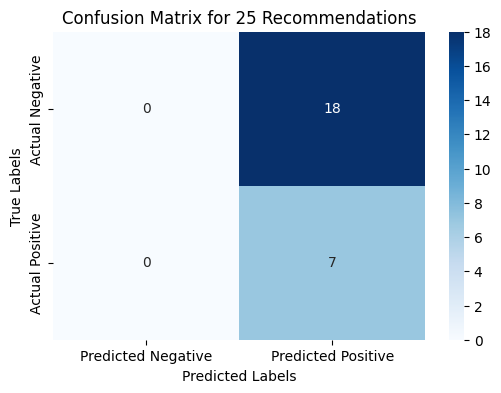

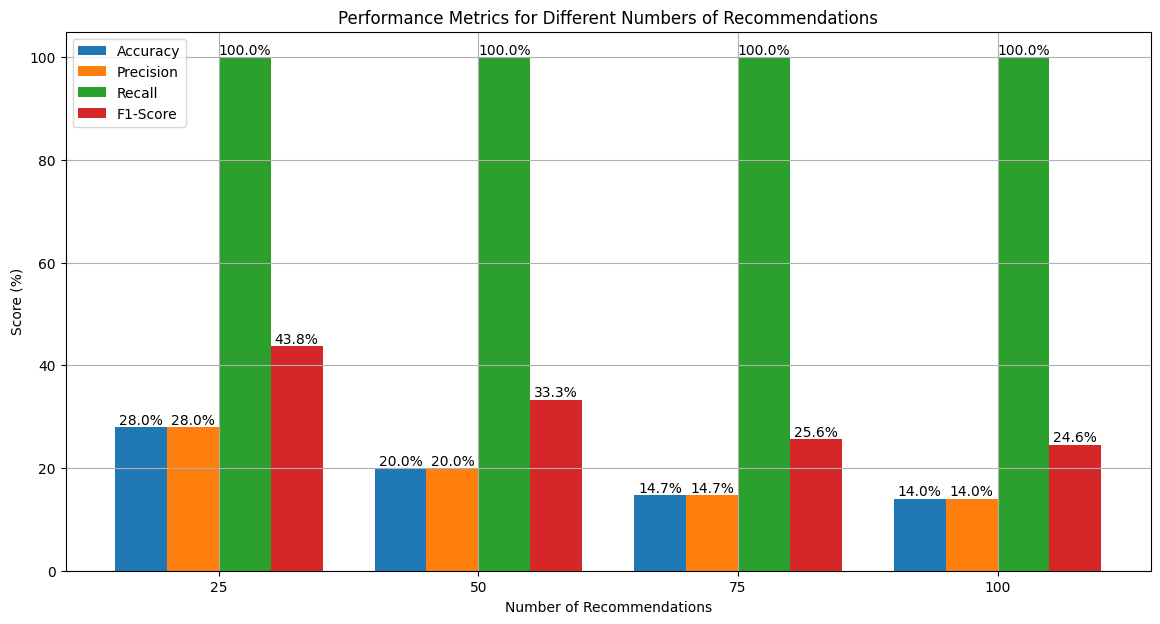

Performance Metrics Table:
   Number of Recommendations  Accuracy (%)  Precision (%)  Recall (%)  \
0                         25     28.000000      28.000000       100.0   
1                         50     20.000000      20.000000       100.0   
2                         75     14.666667      14.666667       100.0   
3                        100     14.000000      14.000000       100.0   

   F1-Score (%)  
0     43.750000  
1     33.333333  
2     25.581395  
3     24.561404  


In [ ]:
# from sklearn.metrics.pairwise import cosine_similarity  # Unused import
# import matplotlib.pyplot as plt
# from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
# import seaborn as sns
# import numpy as np
# import pandas as pd

# # Function to find the ID and title based on an exact title match
# def find_exact_title_match(title_query, df_id1):
#     for idx, row in df_id1.iterrows():
#         if row['title'].strip().lower() == title_query.strip().lower():
#             return row['id'], row['original_title']  # Return the original title for display
#     return None, None  # Return None if no exact match is found

# # Function to calculate Jaccard similarity between two binary arrays
# def jaccard_similarity(set_a, set_b):
#     intersection = np.sum(np.minimum(set_a, set_b))
#     union = np.sum(np.maximum(set_a, set_b))
#     return intersection / union if union != 0 else 0

# # Function to find and rerank similar texts using Jaccard similarity on binary embeddings
# def find_and_rerank_similar_texts(user_query, top_n=5):
#     user_embedding = vectorizer.transform([user_query]).toarray().squeeze()  # Ensure binary form if required
#     similarities = []
    
#     for idx, row in df_id.iterrows():
#         combined_embedding = row['combined_embeddings']
#         jaccard_sim = jaccard_similarity(user_embedding, combined_embedding)
#         similarities.append((row['id'], row['original_title'], jaccard_sim))

#     similarities.sort(key=lambda x: x[2], reverse=True)
#     return similarities[:top_n]

# # Function to recommend papers based on user input using Jaccard similarity
# def recommend_articles(user_query, top_n=5):
#     similar_texts = find_and_rerank_similar_texts(user_query, top_n)
#     recommended_articles = [(id, original_title, score) for id, original_title, score in similar_texts]
#     return recommended_articles

# # Function to evaluate recommendations
# def evaluate_recommendations(recommendations, ground_truth_df, input_id, threshold=0.004):
#     y_true = []
#     y_pred = []
#     true_matches = []

#     input_id_in_references = ground_truth_df[ground_truth_df['id'] == input_id]['references']
#     for recommended_id, title, score in recommendations:
#         is_relevant = False

#         if not input_id_in_references.empty and recommended_id in input_id_in_references.values[0]:
#             is_relevant = True
#             true_matches.append(recommended_id)

#         recommended_id_in_references = ground_truth_df[ground_truth_df['id'] == recommended_id]['references']
#         if (not recommended_id_in_references.empty and input_id in recommended_id_in_references.values[0]):
#             is_relevant = True
#             true_matches.append(recommended_id)

#         y_true.append(1 if is_relevant else 0)
#         y_pred.append(1 if score > threshold else 0)

#     accuracy = accuracy_score(y_true, y_pred)
#     precision = precision_score(y_true, y_pred, zero_division=0)
#     recall = recall_score(y_true, y_pred, zero_division=0)
#     f1 = f1_score(y_true, y_pred, zero_division=0)
#     conf_matrix = confusion_matrix(y_true, y_pred)
#     tn, fp, fn, tp = conf_matrix.ravel() if conf_matrix.size == 4 else (0, 0, 0, 0)

#     return accuracy, precision, recall, f1, (tn, fp, fn, tp), conf_matrix

# # Function to evaluate and store results for different numbers of recommendations
# def evaluate_and_store_results(user_query, ground_truth_df, df_id1, recommendation_func):
#     num_recommendations = [25, 50, 75, 100]
#     accuracies = []
#     precisions = []
#     recalls = []
#     f1_scores = []
#     confusion_matrices = []
#     tp_fps = []

#     exact_match_id, _ = find_exact_title_match(user_query, df_id1)
#     if exact_match_id is None:
#         print(f"No exact title match found for '{user_query}' in df_id1\n")
#         return num_recommendations, accuracies, precisions, recalls, f1_scores, confusion_matrices, tp_fps

#     for n in num_recommendations:
#         recommended_articles = recommendation_func(user_query, top_n=n)
#         if recommended_articles:
#             accuracy, precision, recall, f1, tp_fp, conf_matrix = evaluate_recommendations(recommended_articles, ground_truth_df, exact_match_id)
#             accuracies.append(accuracy)
#             precisions.append(precision)
#             recalls.append(recall)
#             f1_scores.append(f1)
#             confusion_matrices.append(conf_matrix)
#             tp_fps.append(tp_fp)

#     return num_recommendations, accuracies, precisions, recalls, f1_scores, confusion_matrices, tp_fps

# # Example usage
# user_query = "A Tutorial on Support Vector Machines for Pattern Recognition"
# num_recommendations, accuracies, precisions, recalls, f1_scores, confusion_matrices, tp_fps = evaluate_and_store_results(user_query, df_references, df_id1, recommend_articles)

# if accuracies:
#     for i, n in enumerate(num_recommendations):
#         print(f"Number of Recommendations: {n}")
#         print(f"  Accuracy: {accuracies[i] * 100:.2f}%")
#         print(f"  Precision: {precisions[i] * 100:.2f}%")
#         print(f"  Recall: {recalls[i] * 100:.2f}%")
#         print(f"  F1-Score: {f1_scores[i] * 100:.2f}%")
#         tn, fp, fn, tp = tp_fps[i]
#         print(f"  True Negatives: {tn}")
#         print(f"  False Positives: {fp}")
#         print(f"  False Negatives: {fn}")
#         print(f"  True Positives: {tp}")
#         print()

#     # Plot confusion matrix for one set of recommendations (e.g., for 25 recommendations)
#     tn, fp, fn, tp = tp_fps[0]
#     conf_matrix = np.array([[tn, fp], [fn, tp]])

#     plt.figure(figsize=(6, 4))
#     sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
#     plt.title('Confusion Matrix for 25 Recommendations')
#     plt.xlabel('Predicted Labels')
#     plt.ylabel('True Labels')
#     plt.show()

#     # Create a clustered bar chart for Accuracy, Precision, Recall, F1-Score
#     bar_width = 0.2
#     indices = np.arange(len(num_recommendations))

#     plt.figure(figsize=(14, 7))
#     bars_accuracy = plt.bar(indices, [acc * 100 for acc in accuracies], bar_width, label='Accuracy')
#     bars_precision = plt.bar(indices + bar_width, [prec * 100 for prec in precisions], bar_width, label='Precision')
#     bars_recall = plt.bar(indices + 2 * bar_width, [rec * 100 for rec in recalls], bar_width, label='Recall')
#     bars_f1 = plt.bar(indices + 3 * bar_width, [f1 * 100 for f1 in f1_scores], bar_width, label='F1-Score')

#     plt.xlabel('Number of Recommendations')
#     plt.ylabel('Score (%)')
#     plt.title('Performance Metrics for Different Numbers of Recommendations')
#     plt.xticks(indices + 1.5 * bar_width, num_recommendations)

#     def add_text_annotations(bars):
#         for bar in bars:
#             height = bar.get_height()
#             plt.text(
#                 bar.get_x() + bar.get_width() / 2.0,
#                 height,
#                 f'{height:.1f}%',
#                 ha='center',
#                 va='bottom'
#             )

#     add_text_annotations(bars_accuracy)
#     add_text_annotations(bars_precision)
#     add_text_annotations(bars_recall)
#     add_text_annotations(bars_f1)

#     plt.legend()
#     plt.grid(True)
#     plt.show()

#     # Create and display a table of the results
#     results_df = pd.DataFrame({
#         'Number of Recommendations': num_recommendations,
#         'Accuracy (%)': [acc * 100 for acc in accuracies],
#         'Precision (%)': [prec * 100 for prec in precisions],
#         'Recall (%)': [rec * 100 for rec in recalls],
#         'F1-Score (%)': [f1 * 100 for f1 in f1_scores]
#     })

#     print("Performance Metrics Table:")
#     print(results_df)
# else:
#     print("No recommendations evaluated.")


Number of Recommendations: 25
  Accuracy: 16.00%
  Precision: 16.00%
  Recall: 100.00%
  F1-Score: 27.59%
  True Negatives: 0
  False Positives: 21
  False Negatives: 0
  True Positives: 4

Number of Recommendations: 50
  Accuracy: 10.00%
  Precision: 10.00%
  Recall: 100.00%
  F1-Score: 18.18%
  True Negatives: 0
  False Positives: 45
  False Negatives: 0
  True Positives: 5

Number of Recommendations: 75
  Accuracy: 9.33%
  Precision: 9.33%
  Recall: 100.00%
  F1-Score: 17.07%
  True Negatives: 0
  False Positives: 68
  False Negatives: 0
  True Positives: 7

Number of Recommendations: 100
  Accuracy: 10.00%
  Precision: 10.00%
  Recall: 100.00%
  F1-Score: 18.18%
  True Negatives: 0
  False Positives: 90
  False Negatives: 0
  True Positives: 10



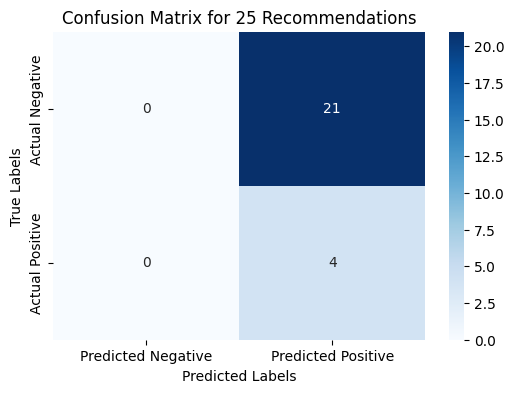

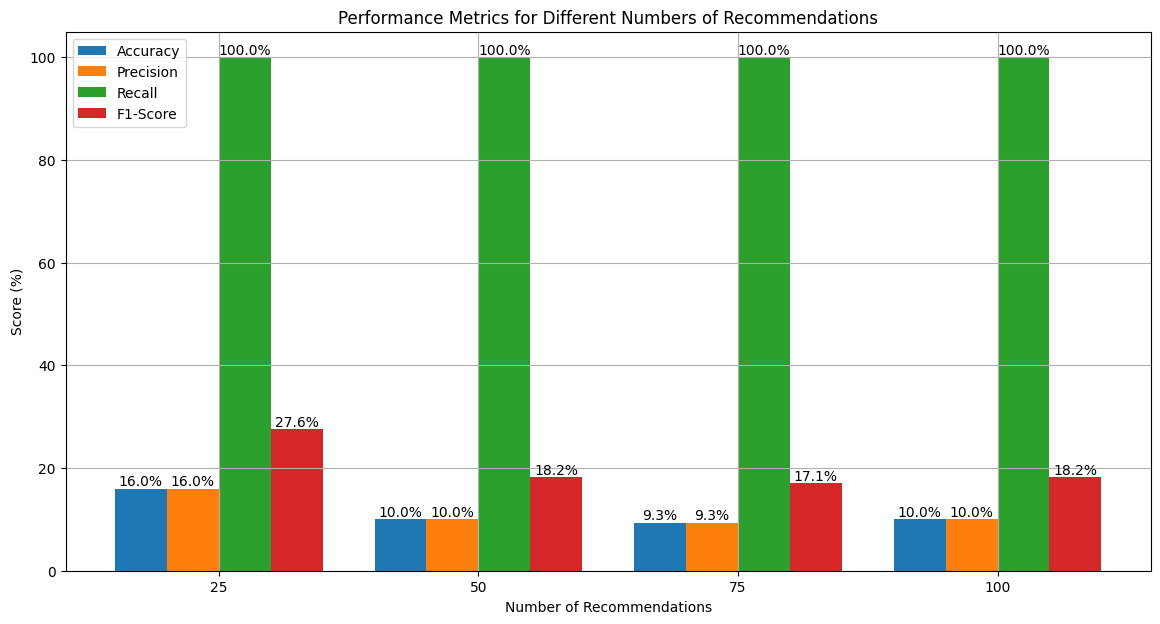

Performance Metrics Table:
   Number of Recommendations  Accuracy (%)  Precision (%)  Recall (%)  \
0                         25     16.000000      16.000000       100.0   
1                         50     10.000000      10.000000       100.0   
2                         75      9.333333       9.333333       100.0   
3                        100     10.000000      10.000000       100.0   

   F1-Score (%)  
0     27.586207  
1     18.181818  
2     17.073171  
3     18.181818  


In [ ]:
# from sklearn.metrics.pairwise import cosine_similarity  # Unused import
# import matplotlib.pyplot as plt
# from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
# import seaborn as sns
# import numpy as np
# import pandas as pd

# # Function to find the ID and title based on an exact title match
# def find_exact_title_match(title_query, df_id1):
#     for idx, row in df_id1.iterrows():
#         if row['title'].strip().lower() == title_query.strip().lower():
#             return row['id'], row['original_title']  # Return the original title for display
#     return None, None  # Return None if no exact match is found

# # Function to calculate Jaccard similarity between two binary arrays
# def jaccard_similarity(set_a, set_b):
#     intersection = np.sum(np.minimum(set_a, set_b))
#     union = np.sum(np.maximum(set_a, set_b))
#     return intersection / union if union != 0 else 0

# # Function to find and rerank similar texts using Jaccard similarity on binary embeddings
# def find_and_rerank_similar_texts(user_query, top_n=5):
#     user_embedding = vectorizer.transform([user_query]).toarray().squeeze()  # Ensure binary form if required
#     similarities = []
    
#     for idx, row in df_id.iterrows():
#         combined_embedding = row['combined_embeddings']
#         jaccard_sim = jaccard_similarity(user_embedding, combined_embedding)
#         similarities.append((row['id'], row['original_title'], jaccard_sim))

#     similarities.sort(key=lambda x: x[2], reverse=True)
#     return similarities[:top_n]

# # Function to recommend papers based on user input using Jaccard similarity
# def recommend_articles(user_query, top_n=5):
#     similar_texts = find_and_rerank_similar_texts(user_query, top_n)
#     recommended_articles = [(id, original_title, score) for id, original_title, score in similar_texts]
#     return recommended_articles

# # Function to evaluate recommendations
# def evaluate_recommendations(recommendations, ground_truth_df, input_id, threshold=0.004):
#     y_true = []
#     y_pred = []
#     true_matches = []

#     input_id_in_references = ground_truth_df[ground_truth_df['id'] == input_id]['references']
#     for recommended_id, title, score in recommendations:
#         is_relevant = False

#         if not input_id_in_references.empty and recommended_id in input_id_in_references.values[0]:
#             is_relevant = True
#             true_matches.append(recommended_id)

#         recommended_id_in_references = ground_truth_df[ground_truth_df['id'] == recommended_id]['references']
#         if (not recommended_id_in_references.empty and input_id in recommended_id_in_references.values[0]):
#             is_relevant = True
#             true_matches.append(recommended_id)

#         y_true.append(1 if is_relevant else 0)
#         y_pred.append(1 if score > threshold else 0)

#     accuracy = accuracy_score(y_true, y_pred)
#     precision = precision_score(y_true, y_pred, zero_division=0)
#     recall = recall_score(y_true, y_pred, zero_division=0)
#     f1 = f1_score(y_true, y_pred, zero_division=0)
#     conf_matrix = confusion_matrix(y_true, y_pred)
#     tn, fp, fn, tp = conf_matrix.ravel() if conf_matrix.size == 4 else (0, 0, 0, 0)

#     return accuracy, precision, recall, f1, (tn, fp, fn, tp), conf_matrix

# # Function to evaluate and store results for different numbers of recommendations
# def evaluate_and_store_results(user_query, ground_truth_df, df_id1, recommendation_func):
#     num_recommendations = [25, 50, 75, 100]
#     accuracies = []
#     precisions = []
#     recalls = []
#     f1_scores = []
#     confusion_matrices = []
#     tp_fps = []

#     exact_match_id, _ = find_exact_title_match(user_query, df_id1)
#     if exact_match_id is None:
#         print(f"No exact title match found for '{user_query}' in df_id1\n")
#         return num_recommendations, accuracies, precisions, recalls, f1_scores, confusion_matrices, tp_fps

#     for n in num_recommendations:
#         recommended_articles = recommendation_func(user_query, top_n=n)
#         if recommended_articles:
#             accuracy, precision, recall, f1, tp_fp, conf_matrix = evaluate_recommendations(recommended_articles, ground_truth_df, exact_match_id)
#             accuracies.append(accuracy)
#             precisions.append(precision)
#             recalls.append(recall)
#             f1_scores.append(f1)
#             confusion_matrices.append(conf_matrix)
#             tp_fps.append(tp_fp)

#     return num_recommendations, accuracies, precisions, recalls, f1_scores, confusion_matrices, tp_fps

# # Example usage
# user_query = "A model of saliency-based visual attention for rapid scene analysis"
# num_recommendations, accuracies, precisions, recalls, f1_scores, confusion_matrices, tp_fps = evaluate_and_store_results(user_query, df_references, df_id1, recommend_articles)

# if accuracies:
#     for i, n in enumerate(num_recommendations):
#         print(f"Number of Recommendations: {n}")
#         print(f"  Accuracy: {accuracies[i] * 100:.2f}%")
#         print(f"  Precision: {precisions[i] * 100:.2f}%")
#         print(f"  Recall: {recalls[i] * 100:.2f}%")
#         print(f"  F1-Score: {f1_scores[i] * 100:.2f}%")
#         tn, fp, fn, tp = tp_fps[i]
#         print(f"  True Negatives: {tn}")
#         print(f"  False Positives: {fp}")
#         print(f"  False Negatives: {fn}")
#         print(f"  True Positives: {tp}")
#         print()

#     # Plot confusion matrix for one set of recommendations (e.g., for 25 recommendations)
#     tn, fp, fn, tp = tp_fps[0]
#     conf_matrix = np.array([[tn, fp], [fn, tp]])

#     plt.figure(figsize=(6, 4))
#     sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
#     plt.title('Confusion Matrix for 25 Recommendations')
#     plt.xlabel('Predicted Labels')
#     plt.ylabel('True Labels')
#     plt.show()

#     # Create a clustered bar chart for Accuracy, Precision, Recall, F1-Score
#     bar_width = 0.2
#     indices = np.arange(len(num_recommendations))

#     plt.figure(figsize=(14, 7))
#     bars_accuracy = plt.bar(indices, [acc * 100 for acc in accuracies], bar_width, label='Accuracy')
#     bars_precision = plt.bar(indices + bar_width, [prec * 100 for prec in precisions], bar_width, label='Precision')
#     bars_recall = plt.bar(indices + 2 * bar_width, [rec * 100 for rec in recalls], bar_width, label='Recall')
#     bars_f1 = plt.bar(indices + 3 * bar_width, [f1 * 100 for f1 in f1_scores], bar_width, label='F1-Score')

#     plt.xlabel('Number of Recommendations')
#     plt.ylabel('Score (%)')
#     plt.title('Performance Metrics for Different Numbers of Recommendations')
#     plt.xticks(indices + 1.5 * bar_width, num_recommendations)

#     def add_text_annotations(bars):
#         for bar in bars:
#             height = bar.get_height()
#             plt.text(
#                 bar.get_x() + bar.get_width() / 2.0,
#                 height,
#                 f'{height:.1f}%',
#                 ha='center',
#                 va='bottom'
#             )

#     add_text_annotations(bars_accuracy)
#     add_text_annotations(bars_precision)
#     add_text_annotations(bars_recall)
#     add_text_annotations(bars_f1)

#     plt.legend()
#     plt.grid(True)
#     plt.show()

#     # Create and display a table of the results
#     results_df = pd.DataFrame({
#         'Number of Recommendations': num_recommendations,
#         'Accuracy (%)': [acc * 100 for acc in accuracies],
#         'Precision (%)': [prec * 100 for prec in precisions],
#         'Recall (%)': [rec * 100 for rec in recalls],
#         'F1-Score (%)': [f1 * 100 for f1 in f1_scores]
#     })

#     print("Performance Metrics Table:")
#     print(results_df)
# else:
#     print("No recommendations evaluated.")


Number of Recommendations: 25
  Accuracy: 16.00%
  Precision: 16.00%
  Recall: 100.00%
  F1-Score: 27.59%
  True Negatives: 0
  False Positives: 21
  False Negatives: 0
  True Positives: 4

Number of Recommendations: 50
  Accuracy: 34.00%
  Precision: 15.38%
  Recall: 100.00%
  F1-Score: 26.67%
  True Negatives: 11
  False Positives: 33
  False Negatives: 0
  True Positives: 6

Number of Recommendations: 75
  Accuracy: 48.00%
  Precision: 15.38%
  Recall: 50.00%
  F1-Score: 23.53%
  True Negatives: 30
  False Positives: 33
  False Negatives: 6
  True Positives: 6

Number of Recommendations: 100
  Accuracy: 58.00%
  Precision: 15.38%
  Recall: 40.00%
  F1-Score: 22.22%
  True Negatives: 52
  False Positives: 33
  False Negatives: 9
  True Positives: 6



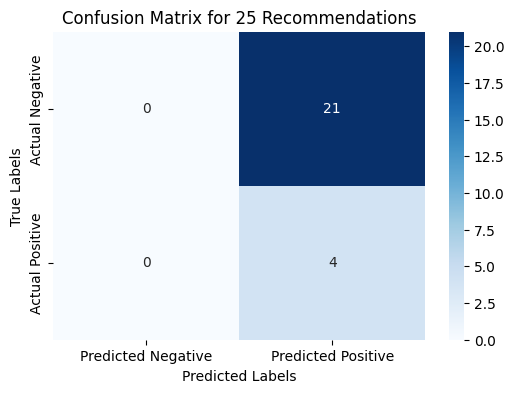

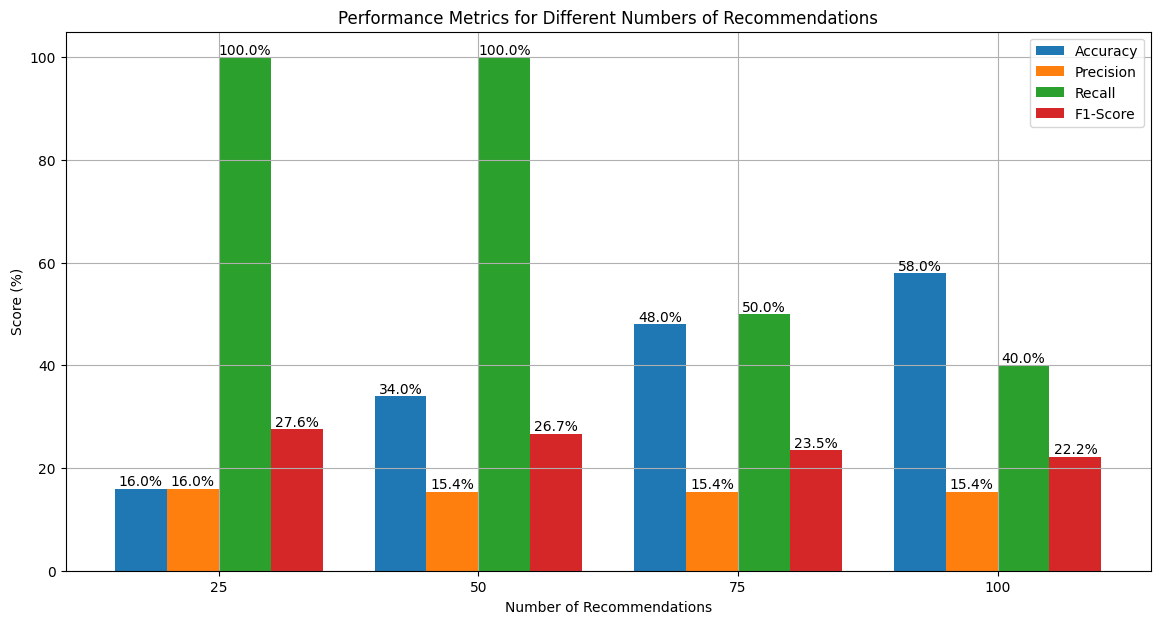

Performance Metrics Table:
   Number of Recommendations  Accuracy (%)  Precision (%)  Recall (%)  \
0                         25          16.0      16.000000       100.0   
1                         50          34.0      15.384615       100.0   
2                         75          48.0      15.384615        50.0   
3                        100          58.0      15.384615        40.0   

   F1-Score (%)  
0     27.586207  
1     26.666667  
2     23.529412  
3     22.222222  


In [73]:
from sklearn.metrics.pairwise import cosine_similarity  # Unused import
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import seaborn as sns
import numpy as np
import pandas as pd

# Function to find the ID and title based on an exact title match
def find_exact_title_match(title_query, df_id1):
    for idx, row in df_id1.iterrows():
        if row['title'].strip().lower() == title_query.strip().lower():
            return row['id'], row['original_title']  # Return the original title for display
    return None, None  # Return None if no exact match is found

# Function to calculate Jaccard similarity between two binary arrays
def jaccard_similarity(set_a, set_b):
    intersection = np.sum(np.minimum(set_a, set_b))
    union = np.sum(np.maximum(set_a, set_b))
    return intersection / union if union != 0 else 0

# Function to find and rerank similar texts using Jaccard similarity on binary embeddings
def find_and_rerank_similar_texts(user_query, top_n=5):
    user_embedding = vectorizer.transform([user_query]).toarray().squeeze()  # Ensure binary form if required
    similarities = []
    
    for idx, row in df_id.iterrows():
        combined_embedding = row['combined_embeddings']
        jaccard_sim = jaccard_similarity(user_embedding, combined_embedding)
        similarities.append((row['id'], row['original_title'], jaccard_sim))

    similarities.sort(key=lambda x: x[2], reverse=True)
    return similarities[:top_n]

# Function to recommend papers based on user input using Jaccard similarity
def recommend_articles(user_query, top_n=5):
    similar_texts = find_and_rerank_similar_texts(user_query, top_n)
    recommended_articles = [(id, original_title, score) for id, original_title, score in similar_texts]
    return recommended_articles

# Function to evaluate recommendations
def evaluate_recommendations(recommendations, ground_truth_df, input_id, threshold=0.2):
    y_true = []
    y_pred = []
    true_matches = []

    input_id_in_references = ground_truth_df[ground_truth_df['id'] == input_id]['references']
    for recommended_id, title, score in recommendations:
        is_relevant = False

        if not input_id_in_references.empty and recommended_id in input_id_in_references.values[0]:
            is_relevant = True
            true_matches.append(recommended_id)

        recommended_id_in_references = ground_truth_df[ground_truth_df['id'] == recommended_id]['references']
        if (not recommended_id_in_references.empty and input_id in recommended_id_in_references.values[0]):
            is_relevant = True
            true_matches.append(recommended_id)

        y_true.append(1 if is_relevant else 0)
        y_pred.append(1 if score > threshold else 0)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    conf_matrix = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel() if conf_matrix.size == 4 else (0, 0, 0, 0)

    return accuracy, precision, recall, f1, (tn, fp, fn, tp), conf_matrix

# Function to evaluate and store results for different numbers of recommendations
def evaluate_and_store_results(user_query, ground_truth_df, df_id1, recommendation_func):
    num_recommendations = [25, 50, 75, 100]
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    confusion_matrices = []
    tp_fps = []

    exact_match_id, _ = find_exact_title_match(user_query, df_id1)
    if exact_match_id is None:
        print(f"No exact title match found for '{user_query}' in df_id1\n")
        return num_recommendations, accuracies, precisions, recalls, f1_scores, confusion_matrices, tp_fps

    for n in num_recommendations:
        recommended_articles = recommendation_func(user_query, top_n=n)
        if recommended_articles:
            accuracy, precision, recall, f1, tp_fp, conf_matrix = evaluate_recommendations(recommended_articles, ground_truth_df, exact_match_id)
            accuracies.append(accuracy)
            precisions.append(precision)
            recalls.append(recall)
            f1_scores.append(f1)
            confusion_matrices.append(conf_matrix)
            tp_fps.append(tp_fp)

    return num_recommendations, accuracies, precisions, recalls, f1_scores, confusion_matrices, tp_fps

# Example usage
user_query = "Identification and control of dynamical systems using neural networks"
num_recommendations, accuracies, precisions, recalls, f1_scores, confusion_matrices, tp_fps = evaluate_and_store_results(user_query, df_references, df_id1, recommend_articles)

if accuracies:
    for i, n in enumerate(num_recommendations):
        print(f"Number of Recommendations: {n}")
        print(f"  Accuracy: {accuracies[i] * 100:.2f}%")
        print(f"  Precision: {precisions[i] * 100:.2f}%")
        print(f"  Recall: {recalls[i] * 100:.2f}%")
        print(f"  F1-Score: {f1_scores[i] * 100:.2f}%")
        tn, fp, fn, tp = tp_fps[i]
        print(f"  True Negatives: {tn}")
        print(f"  False Positives: {fp}")
        print(f"  False Negatives: {fn}")
        print(f"  True Positives: {tp}")
        print()

    # Plot confusion matrix for one set of recommendations (e.g., for 25 recommendations)
    tn, fp, fn, tp = tp_fps[0]
    conf_matrix = np.array([[tn, fp], [fn, tp]])

    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
    plt.title('Confusion Matrix for 25 Recommendations')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Create a clustered bar chart for Accuracy, Precision, Recall, F1-Score
    bar_width = 0.2
    indices = np.arange(len(num_recommendations))

    plt.figure(figsize=(14, 7))
    bars_accuracy = plt.bar(indices, [acc * 100 for acc in accuracies], bar_width, label='Accuracy')
    bars_precision = plt.bar(indices + bar_width, [prec * 100 for prec in precisions], bar_width, label='Precision')
    bars_recall = plt.bar(indices + 2 * bar_width, [rec * 100 for rec in recalls], bar_width, label='Recall')
    bars_f1 = plt.bar(indices + 3 * bar_width, [f1 * 100 for f1 in f1_scores], bar_width, label='F1-Score')

    plt.xlabel('Number of Recommendations')
    plt.ylabel('Score (%)')
    plt.title('Performance Metrics for Different Numbers of Recommendations')
    plt.xticks(indices + 1.5 * bar_width, num_recommendations)

    def add_text_annotations(bars):
        for bar in bars:
            height = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width() / 2.0,
                height,
                f'{height:.1f}%',
                ha='center',
                va='bottom'
            )

    add_text_annotations(bars_accuracy)
    add_text_annotations(bars_precision)
    add_text_annotations(bars_recall)
    add_text_annotations(bars_f1)

    plt.legend()
    plt.grid(True)
    plt.show()

    # Create and display a table of the results
    results_df = pd.DataFrame({
        'Number of Recommendations': num_recommendations,
        'Accuracy (%)': [acc * 100 for acc in accuracies],
        'Precision (%)': [prec * 100 for prec in precisions],
        'Recall (%)': [rec * 100 for rec in recalls],
        'F1-Score (%)': [f1 * 100 for f1 in f1_scores]
    })

    print("Performance Metrics Table:")
    print(results_df)
else:
    print("No recommendations evaluated.")


Number of Recommendations: 25
  Accuracy: 40.00%
  Precision: 6.25%
  Recall: 100.00%
  F1-Score: 11.76%
  True Negatives: 9
  False Positives: 15
  False Negatives: 0
  True Positives: 1

Number of Recommendations: 50
  Accuracy: 64.00%
  Precision: 6.25%
  Recall: 25.00%
  F1-Score: 10.00%
  True Negatives: 31
  False Positives: 15
  False Negatives: 3
  True Positives: 1

Number of Recommendations: 75
  Accuracy: 74.67%
  Precision: 6.25%
  Recall: 20.00%
  F1-Score: 9.52%
  True Negatives: 55
  False Positives: 15
  False Negatives: 4
  True Positives: 1

Number of Recommendations: 100
  Accuracy: 80.00%
  Precision: 6.25%
  Recall: 16.67%
  F1-Score: 9.09%
  True Negatives: 79
  False Positives: 15
  False Negatives: 5
  True Positives: 1



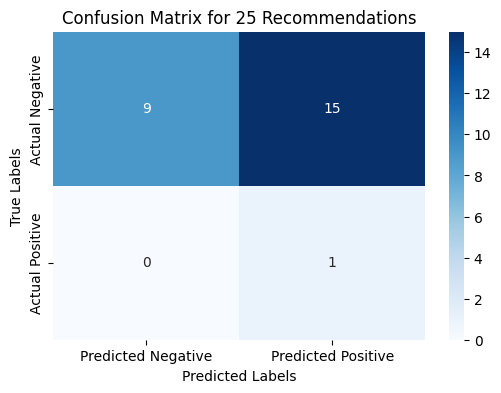

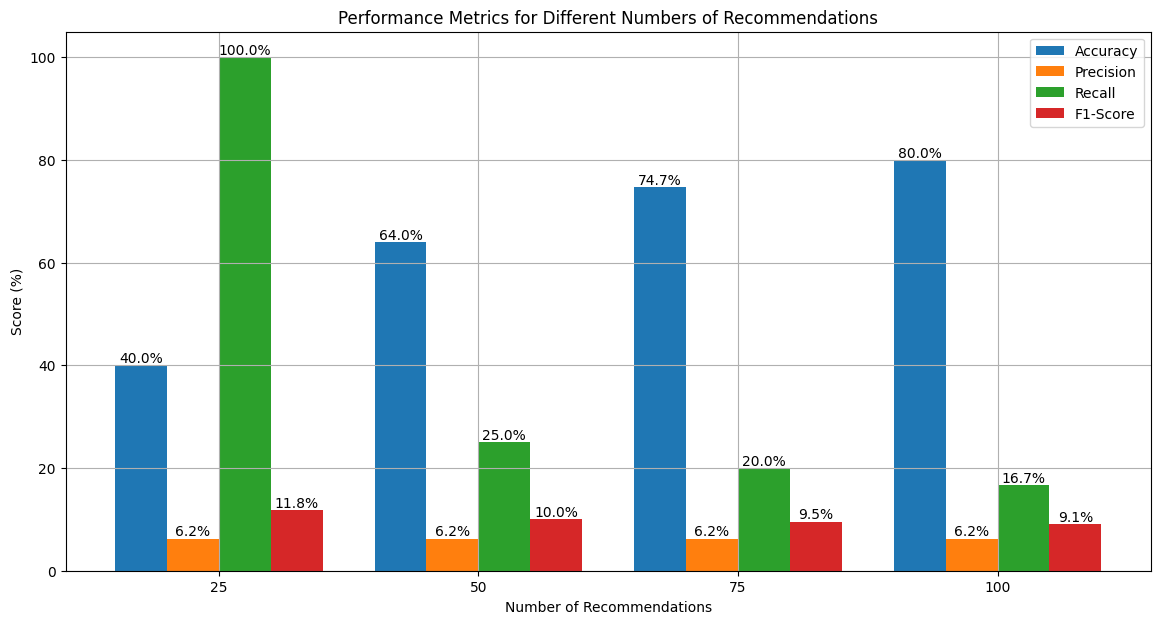

Performance Metrics Table:
   Number of Recommendations  Accuracy (%)  Precision (%)  Recall (%)  \
0                         25     40.000000           6.25  100.000000   
1                         50     64.000000           6.25   25.000000   
2                         75     74.666667           6.25   20.000000   
3                        100     80.000000           6.25   16.666667   

   F1-Score (%)  
0     11.764706  
1     10.000000  
2      9.523810  
3      9.090909  


In [74]:
from sklearn.metrics.pairwise import cosine_similarity  # Unused import
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import seaborn as sns
import numpy as np
import pandas as pd

# Function to find the ID and title based on an exact title match
def find_exact_title_match(title_query, df_id1):
    for idx, row in df_id1.iterrows():
        if row['title'].strip().lower() == title_query.strip().lower():
            return row['id'], row['original_title']  # Return the original title for display
    return None, None  # Return None if no exact match is found

# Function to calculate Jaccard similarity between two binary arrays
def jaccard_similarity(set_a, set_b):
    intersection = np.sum(np.minimum(set_a, set_b))
    union = np.sum(np.maximum(set_a, set_b))
    return intersection / union if union != 0 else 0

# Function to find and rerank similar texts using Jaccard similarity on binary embeddings
def find_and_rerank_similar_texts(user_query, top_n=5):
    user_embedding = vectorizer.transform([user_query]).toarray().squeeze()  # Ensure binary form if required
    similarities = []
    
    for idx, row in df_id.iterrows():
        combined_embedding = row['combined_embeddings']
        jaccard_sim = jaccard_similarity(user_embedding, combined_embedding)
        similarities.append((row['id'], row['original_title'], jaccard_sim))

    similarities.sort(key=lambda x: x[2], reverse=True)
    return similarities[:top_n]

# Function to recommend papers based on user input using Jaccard similarity
def recommend_articles(user_query, top_n=5):
    similar_texts = find_and_rerank_similar_texts(user_query, top_n)
    recommended_articles = [(id, original_title, score) for id, original_title, score in similar_texts]
    return recommended_articles

# Function to evaluate recommendations
def evaluate_recommendations(recommendations, ground_truth_df, input_id, threshold=0.2):
    y_true = []
    y_pred = []
    true_matches = []

    input_id_in_references = ground_truth_df[ground_truth_df['id'] == input_id]['references']
    for recommended_id, title, score in recommendations:
        is_relevant = False

        if not input_id_in_references.empty and recommended_id in input_id_in_references.values[0]:
            is_relevant = True
            true_matches.append(recommended_id)

        recommended_id_in_references = ground_truth_df[ground_truth_df['id'] == recommended_id]['references']
        if (not recommended_id_in_references.empty and input_id in recommended_id_in_references.values[0]):
            is_relevant = True
            true_matches.append(recommended_id)

        y_true.append(1 if is_relevant else 0)
        y_pred.append(1 if score > threshold else 0)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    conf_matrix = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel() if conf_matrix.size == 4 else (0, 0, 0, 0)

    return accuracy, precision, recall, f1, (tn, fp, fn, tp), conf_matrix

# Function to evaluate and store results for different numbers of recommendations
def evaluate_and_store_results(user_query, ground_truth_df, df_id1, recommendation_func):
    num_recommendations = [25, 50, 75, 100]
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    confusion_matrices = []
    tp_fps = []

    exact_match_id, _ = find_exact_title_match(user_query, df_id1)
    if exact_match_id is None:
        print(f"No exact title match found for '{user_query}' in df_id1\n")
        return num_recommendations, accuracies, precisions, recalls, f1_scores, confusion_matrices, tp_fps

    for n in num_recommendations:
        recommended_articles = recommendation_func(user_query, top_n=n)
        if recommended_articles:
            accuracy, precision, recall, f1, tp_fp, conf_matrix = evaluate_recommendations(recommended_articles, ground_truth_df, exact_match_id)
            accuracies.append(accuracy)
            precisions.append(precision)
            recalls.append(recall)
            f1_scores.append(f1)
            confusion_matrices.append(conf_matrix)
            tp_fps.append(tp_fp)

    return num_recommendations, accuracies, precisions, recalls, f1_scores, confusion_matrices, tp_fps

# Example usage
user_query = "Gene Selection for Cancer Classification using Support Vector Machines"
num_recommendations, accuracies, precisions, recalls, f1_scores, confusion_matrices, tp_fps = evaluate_and_store_results(user_query, df_references, df_id1, recommend_articles)

if accuracies:
    for i, n in enumerate(num_recommendations):
        print(f"Number of Recommendations: {n}")
        print(f"  Accuracy: {accuracies[i] * 100:.2f}%")
        print(f"  Precision: {precisions[i] * 100:.2f}%")
        print(f"  Recall: {recalls[i] * 100:.2f}%")
        print(f"  F1-Score: {f1_scores[i] * 100:.2f}%")
        tn, fp, fn, tp = tp_fps[i]
        print(f"  True Negatives: {tn}")
        print(f"  False Positives: {fp}")
        print(f"  False Negatives: {fn}")
        print(f"  True Positives: {tp}")
        print()

    # Plot confusion matrix for one set of recommendations (e.g., for 25 recommendations)
    tn, fp, fn, tp = tp_fps[0]
    conf_matrix = np.array([[tn, fp], [fn, tp]])

    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
    plt.title('Confusion Matrix for 25 Recommendations')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Create a clustered bar chart for Accuracy, Precision, Recall, F1-Score
    bar_width = 0.2
    indices = np.arange(len(num_recommendations))

    plt.figure(figsize=(14, 7))
    bars_accuracy = plt.bar(indices, [acc * 100 for acc in accuracies], bar_width, label='Accuracy')
    bars_precision = plt.bar(indices + bar_width, [prec * 100 for prec in precisions], bar_width, label='Precision')
    bars_recall = plt.bar(indices + 2 * bar_width, [rec * 100 for rec in recalls], bar_width, label='Recall')
    bars_f1 = plt.bar(indices + 3 * bar_width, [f1 * 100 for f1 in f1_scores], bar_width, label='F1-Score')

    plt.xlabel('Number of Recommendations')
    plt.ylabel('Score (%)')
    plt.title('Performance Metrics for Different Numbers of Recommendations')
    plt.xticks(indices + 1.5 * bar_width, num_recommendations)

    def add_text_annotations(bars):
        for bar in bars:
            height = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width() / 2.0,
                height,
                f'{height:.1f}%',
                ha='center',
                va='bottom'
            )

    add_text_annotations(bars_accuracy)
    add_text_annotations(bars_precision)
    add_text_annotations(bars_recall)
    add_text_annotations(bars_f1)

    plt.legend()
    plt.grid(True)
    plt.show()

    # Create and display a table of the results
    results_df = pd.DataFrame({
        'Number of Recommendations': num_recommendations,
        'Accuracy (%)': [acc * 100 for acc in accuracies],
        'Precision (%)': [prec * 100 for prec in precisions],
        'Recall (%)': [rec * 100 for rec in recalls],
        'F1-Score (%)': [f1 * 100 for f1 in f1_scores]
    })

    print("Performance Metrics Table:")
    print(results_df)
else:
    print("No recommendations evaluated.")


Number of Recommendations: 25
  Accuracy: 52.00%
  Precision: 0.00%
  Recall: 0.00%
  F1-Score: 0.00%
  True Negatives: 13
  False Positives: 5
  False Negatives: 7
  True Positives: 0

Number of Recommendations: 50
  Accuracy: 70.00%
  Precision: 0.00%
  Recall: 0.00%
  F1-Score: 0.00%
  True Negatives: 35
  False Positives: 5
  False Negatives: 10
  True Positives: 0

Number of Recommendations: 75
  Accuracy: 78.67%
  Precision: 0.00%
  Recall: 0.00%
  F1-Score: 0.00%
  True Negatives: 59
  False Positives: 5
  False Negatives: 11
  True Positives: 0

Number of Recommendations: 100
  Accuracy: 81.00%
  Precision: 0.00%
  Recall: 0.00%
  F1-Score: 0.00%
  True Negatives: 81
  False Positives: 5
  False Negatives: 14
  True Positives: 0



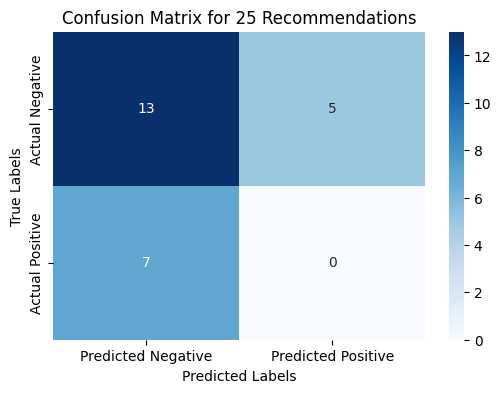

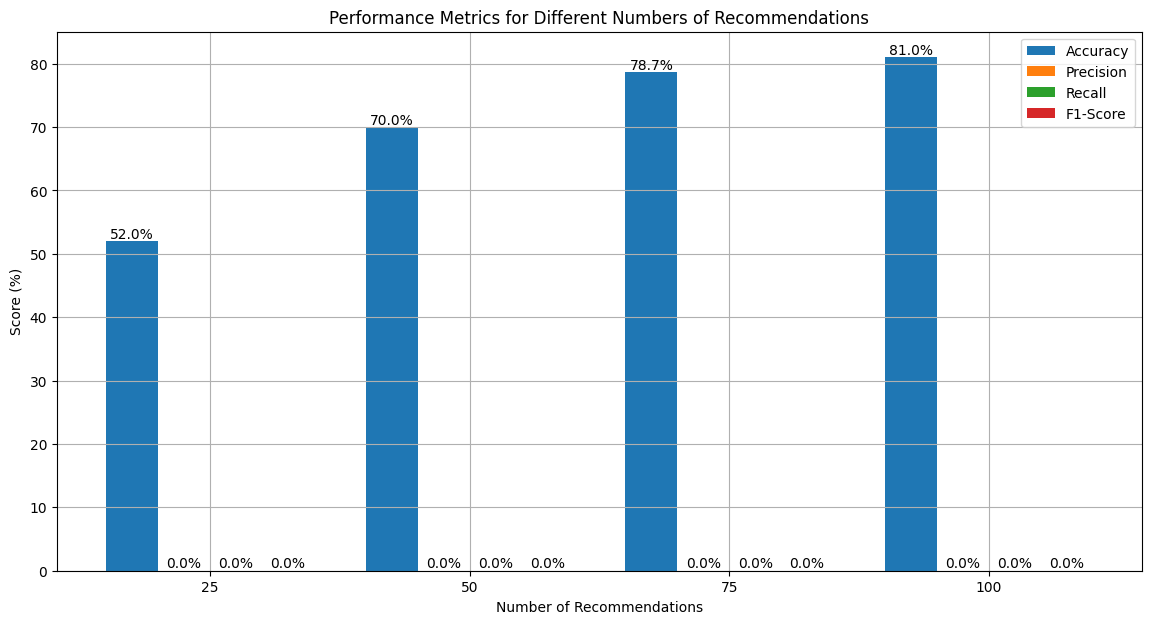

Performance Metrics Table:
   Number of Recommendations  Accuracy (%)  Precision (%)  Recall (%)  \
0                         25     52.000000            0.0         0.0   
1                         50     70.000000            0.0         0.0   
2                         75     78.666667            0.0         0.0   
3                        100     81.000000            0.0         0.0   

   F1-Score (%)  
0           0.0  
1           0.0  
2           0.0  
3           0.0  


In [82]:
from sklearn.metrics.pairwise import cosine_similarity  # Unused import
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import seaborn as sns
import numpy as np
import pandas as pd

# Function to find the ID and title based on an exact title match
def find_exact_title_match(title_query, df_id1):
    for idx, row in df_id1.iterrows():
        if row['title'].strip().lower() == title_query.strip().lower():
            return row['id'], row['original_title']  # Return the original title for display
    return None, None  # Return None if no exact match is found

# Function to calculate Jaccard similarity between two binary arrays
def jaccard_similarity(set_a, set_b):
    intersection = np.sum(np.minimum(set_a, set_b))
    union = np.sum(np.maximum(set_a, set_b))
    return intersection / union if union != 0 else 0

# Function to find and rerank similar texts using Jaccard similarity on binary embeddings
def find_and_rerank_similar_texts(user_query, top_n=5):
    user_embedding = vectorizer.transform([user_query]).toarray().squeeze()  # Ensure binary form if required
    similarities = []
    
    for idx, row in df_id.iterrows():
        combined_embedding = row['combined_embeddings']
        jaccard_sim = jaccard_similarity(user_embedding, combined_embedding)
        similarities.append((row['id'], row['original_title'], jaccard_sim))

    similarities.sort(key=lambda x: x[2], reverse=True)
    return similarities[:top_n]

# Function to recommend papers based on user input using Jaccard similarity
def recommend_articles(user_query, top_n=5):
    similar_texts = find_and_rerank_similar_texts(user_query, top_n)
    recommended_articles = [(id, original_title, score) for id, original_title, score in similar_texts]
    return recommended_articles

# Function to evaluate recommendations
def evaluate_recommendations(recommendations, ground_truth_df, input_id, threshold=0.2):
    y_true = []
    y_pred = []
    true_matches = []

    input_id_in_references = ground_truth_df[ground_truth_df['id'] == input_id]['references']
    for recommended_id, title, score in recommendations:
        is_relevant = False

        if not input_id_in_references.empty and recommended_id in input_id_in_references.values[0]:
            is_relevant = True
            true_matches.append(recommended_id)

        recommended_id_in_references = ground_truth_df[ground_truth_df['id'] == recommended_id]['references']
        if (not recommended_id_in_references.empty and input_id in recommended_id_in_references.values[0]):
            is_relevant = True
            true_matches.append(recommended_id)

        y_true.append(1 if is_relevant else 0)
        y_pred.append(1 if score > threshold else 0)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    conf_matrix = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel() if conf_matrix.size == 4 else (0, 0, 0, 0)

    return accuracy, precision, recall, f1, (tn, fp, fn, tp), conf_matrix

# Function to evaluate and store results for different numbers of recommendations
def evaluate_and_store_results(user_query, ground_truth_df, df_id1, recommendation_func):
    num_recommendations = [25, 50, 75, 100]
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    confusion_matrices = []
    tp_fps = []

    exact_match_id, _ = find_exact_title_match(user_query, df_id1)
    if exact_match_id is None:
        print(f"No exact title match found for '{user_query}' in df_id1\n")
        return num_recommendations, accuracies, precisions, recalls, f1_scores, confusion_matrices, tp_fps

    for n in num_recommendations:
        recommended_articles = recommendation_func(user_query, top_n=n)
        if recommended_articles:
            accuracy, precision, recall, f1, tp_fp, conf_matrix = evaluate_recommendations(recommended_articles, ground_truth_df, exact_match_id)
            accuracies.append(accuracy)
            precisions.append(precision)
            recalls.append(recall)
            f1_scores.append(f1)
            confusion_matrices.append(conf_matrix)
            tp_fps.append(tp_fp)

    return num_recommendations, accuracies, precisions, recalls, f1_scores, confusion_matrices, tp_fps

# Example usage
user_query = "A Tutorial on Support Vector Machines for Pattern Recognition"
num_recommendations, accuracies, precisions, recalls, f1_scores, confusion_matrices, tp_fps = evaluate_and_store_results(user_query, df_references, df_id1, recommend_articles)

if accuracies:
    for i, n in enumerate(num_recommendations):
        print(f"Number of Recommendations: {n}")
        print(f"  Accuracy: {accuracies[i] * 100:.2f}%")
        print(f"  Precision: {precisions[i] * 100:.2f}%")
        print(f"  Recall: {recalls[i] * 100:.2f}%")
        print(f"  F1-Score: {f1_scores[i] * 100:.2f}%")
        tn, fp, fn, tp = tp_fps[i]
        print(f"  True Negatives: {tn}")
        print(f"  False Positives: {fp}")
        print(f"  False Negatives: {fn}")
        print(f"  True Positives: {tp}")
        print()

    # Plot confusion matrix for one set of recommendations (e.g., for 25 recommendations)
    tn, fp, fn, tp = tp_fps[0]
    conf_matrix = np.array([[tn, fp], [fn, tp]])

    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
    plt.title('Confusion Matrix for 25 Recommendations')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Create a clustered bar chart for Accuracy, Precision, Recall, F1-Score
    bar_width = 0.2
    indices = np.arange(len(num_recommendations))

    plt.figure(figsize=(14, 7))
    bars_accuracy = plt.bar(indices, [acc * 100 for acc in accuracies], bar_width, label='Accuracy')
    bars_precision = plt.bar(indices + bar_width, [prec * 100 for prec in precisions], bar_width, label='Precision')
    bars_recall = plt.bar(indices + 2 * bar_width, [rec * 100 for rec in recalls], bar_width, label='Recall')
    bars_f1 = plt.bar(indices + 3 * bar_width, [f1 * 100 for f1 in f1_scores], bar_width, label='F1-Score')

    plt.xlabel('Number of Recommendations')
    plt.ylabel('Score (%)')
    plt.title('Performance Metrics for Different Numbers of Recommendations')
    plt.xticks(indices + 1.5 * bar_width, num_recommendations)

    def add_text_annotations(bars):
        for bar in bars:
            height = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width() / 2.0,
                height,
                f'{height:.1f}%',
                ha='center',
                va='bottom'
            )

    add_text_annotations(bars_accuracy)
    add_text_annotations(bars_precision)
    add_text_annotations(bars_recall)
    add_text_annotations(bars_f1)

    plt.legend()
    plt.grid(True)
    plt.show()

    # Create and display a table of the results
    results_df = pd.DataFrame({
        'Number of Recommendations': num_recommendations,
        'Accuracy (%)': [acc * 100 for acc in accuracies],
        'Precision (%)': [prec * 100 for prec in precisions],
        'Recall (%)': [rec * 100 for rec in recalls],
        'F1-Score (%)': [f1 * 100 for f1 in f1_scores]
    })

    print("Performance Metrics Table:")
    print(results_df)
else:
    print("No recommendations evaluated.")


Number of Recommendations: 25
  Accuracy: 44.00%
  Precision: 13.33%
  Recall: 66.67%
  F1-Score: 22.22%
  True Negatives: 9
  False Positives: 13
  False Negatives: 1
  True Positives: 2

Number of Recommendations: 50
  Accuracy: 70.00%
  Precision: 13.33%
  Recall: 50.00%
  F1-Score: 21.05%
  True Negatives: 33
  False Positives: 13
  False Negatives: 2
  True Positives: 2

Number of Recommendations: 75
  Accuracy: 76.00%
  Precision: 13.33%
  Recall: 28.57%
  F1-Score: 18.18%
  True Negatives: 55
  False Positives: 13
  False Negatives: 5
  True Positives: 2

Number of Recommendations: 100
  Accuracy: 79.00%
  Precision: 13.33%
  Recall: 20.00%
  F1-Score: 16.00%
  True Negatives: 77
  False Positives: 13
  False Negatives: 8
  True Positives: 2



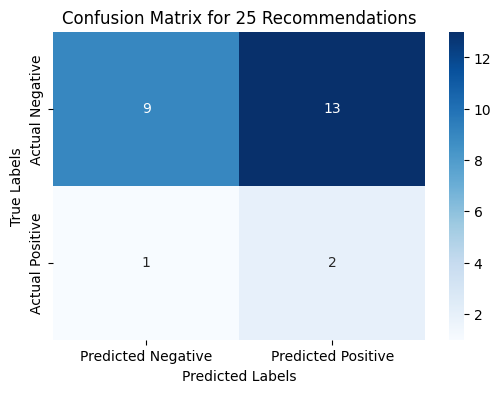

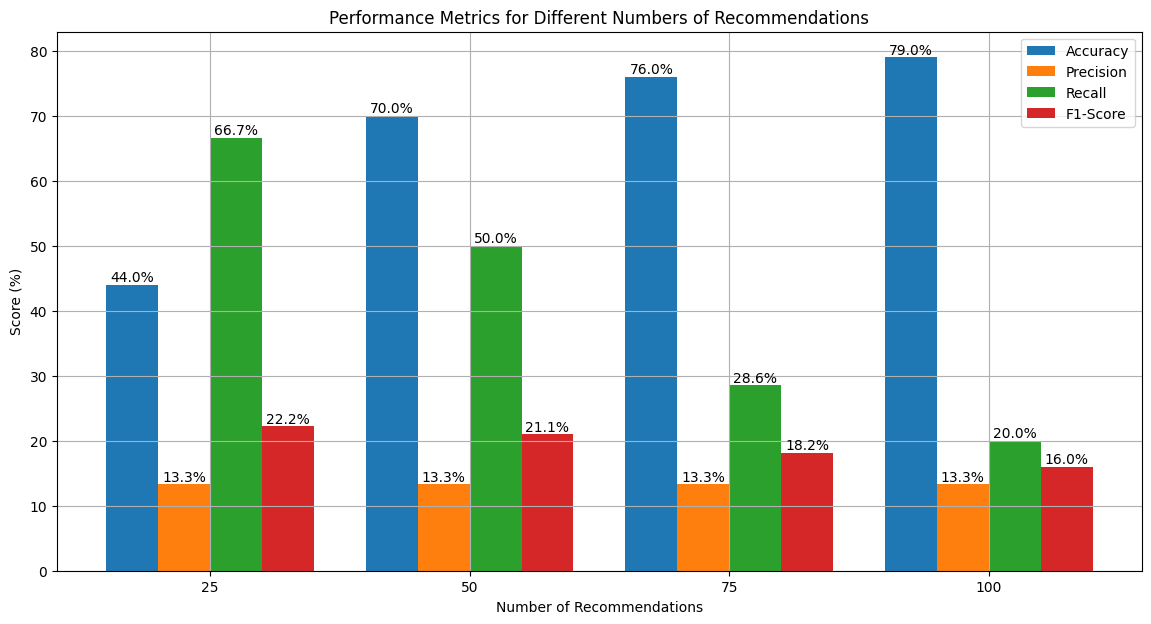

Performance Metrics Table:
   Number of Recommendations  Accuracy (%)  Precision (%)  Recall (%)  \
0                         25          44.0      13.333333   66.666667   
1                         50          70.0      13.333333   50.000000   
2                         75          76.0      13.333333   28.571429   
3                        100          79.0      13.333333   20.000000   

   F1-Score (%)  
0     22.222222  
1     21.052632  
2     18.181818  
3     16.000000  


In [76]:
from sklearn.metrics.pairwise import cosine_similarity  # Unused import
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import seaborn as sns
import numpy as np
import pandas as pd

# Function to find the ID and title based on an exact title match
def find_exact_title_match(title_query, df_id1):
    for idx, row in df_id1.iterrows():
        if row['title'].strip().lower() == title_query.strip().lower():
            return row['id'], row['original_title']  # Return the original title for display
    return None, None  # Return None if no exact match is found

# Function to calculate Jaccard similarity between two binary arrays
def jaccard_similarity(set_a, set_b):
    intersection = np.sum(np.minimum(set_a, set_b))
    union = np.sum(np.maximum(set_a, set_b))
    return intersection / union if union != 0 else 0

# Function to find and rerank similar texts using Jaccard similarity on binary embeddings
def find_and_rerank_similar_texts(user_query, top_n=5):
    user_embedding = vectorizer.transform([user_query]).toarray().squeeze()  # Ensure binary form if required
    similarities = []
    
    for idx, row in df_id.iterrows():
        combined_embedding = row['combined_embeddings']
        jaccard_sim = jaccard_similarity(user_embedding, combined_embedding)
        similarities.append((row['id'], row['original_title'], jaccard_sim))

    similarities.sort(key=lambda x: x[2], reverse=True)
    return similarities[:top_n]

# Function to recommend papers based on user input using Jaccard similarity
def recommend_articles(user_query, top_n=5):
    similar_texts = find_and_rerank_similar_texts(user_query, top_n)
    recommended_articles = [(id, original_title, score) for id, original_title, score in similar_texts]
    return recommended_articles

# Function to evaluate recommendations
def evaluate_recommendations(recommendations, ground_truth_df, input_id, threshold=0.2):
    y_true = []
    y_pred = []
    true_matches = []

    input_id_in_references = ground_truth_df[ground_truth_df['id'] == input_id]['references']
    for recommended_id, title, score in recommendations:
        is_relevant = False

        if not input_id_in_references.empty and recommended_id in input_id_in_references.values[0]:
            is_relevant = True
            true_matches.append(recommended_id)

        recommended_id_in_references = ground_truth_df[ground_truth_df['id'] == recommended_id]['references']
        if (not recommended_id_in_references.empty and input_id in recommended_id_in_references.values[0]):
            is_relevant = True
            true_matches.append(recommended_id)

        y_true.append(1 if is_relevant else 0)
        y_pred.append(1 if score > threshold else 0)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    conf_matrix = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel() if conf_matrix.size == 4 else (0, 0, 0, 0)

    return accuracy, precision, recall, f1, (tn, fp, fn, tp), conf_matrix

# Function to evaluate and store results for different numbers of recommendations
def evaluate_and_store_results(user_query, ground_truth_df, df_id1, recommendation_func):
    num_recommendations = [25, 50, 75, 100]
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    confusion_matrices = []
    tp_fps = []

    exact_match_id, _ = find_exact_title_match(user_query, df_id1)
    if exact_match_id is None:
        print(f"No exact title match found for '{user_query}' in df_id1\n")
        return num_recommendations, accuracies, precisions, recalls, f1_scores, confusion_matrices, tp_fps

    for n in num_recommendations:
        recommended_articles = recommendation_func(user_query, top_n=n)
        if recommended_articles:
            accuracy, precision, recall, f1, tp_fp, conf_matrix = evaluate_recommendations(recommended_articles, ground_truth_df, exact_match_id)
            accuracies.append(accuracy)
            precisions.append(precision)
            recalls.append(recall)
            f1_scores.append(f1)
            confusion_matrices.append(conf_matrix)
            tp_fps.append(tp_fp)

    return num_recommendations, accuracies, precisions, recalls, f1_scores, confusion_matrices, tp_fps

# Example usage
user_query = "Support-Vector Networks"
num_recommendations, accuracies, precisions, recalls, f1_scores, confusion_matrices, tp_fps = evaluate_and_store_results(user_query, df_references, df_id1, recommend_articles)

if accuracies:
    for i, n in enumerate(num_recommendations):
        print(f"Number of Recommendations: {n}")
        print(f"  Accuracy: {accuracies[i] * 100:.2f}%")
        print(f"  Precision: {precisions[i] * 100:.2f}%")
        print(f"  Recall: {recalls[i] * 100:.2f}%")
        print(f"  F1-Score: {f1_scores[i] * 100:.2f}%")
        tn, fp, fn, tp = tp_fps[i]
        print(f"  True Negatives: {tn}")
        print(f"  False Positives: {fp}")
        print(f"  False Negatives: {fn}")
        print(f"  True Positives: {tp}")
        print()

    # Plot confusion matrix for one set of recommendations (e.g., for 25 recommendations)
    tn, fp, fn, tp = tp_fps[0]
    conf_matrix = np.array([[tn, fp], [fn, tp]])

    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
    plt.title('Confusion Matrix for 25 Recommendations')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Create a clustered bar chart for Accuracy, Precision, Recall, F1-Score
    bar_width = 0.2
    indices = np.arange(len(num_recommendations))

    plt.figure(figsize=(14, 7))
    bars_accuracy = plt.bar(indices, [acc * 100 for acc in accuracies], bar_width, label='Accuracy')
    bars_precision = plt.bar(indices + bar_width, [prec * 100 for prec in precisions], bar_width, label='Precision')
    bars_recall = plt.bar(indices + 2 * bar_width, [rec * 100 for rec in recalls], bar_width, label='Recall')
    bars_f1 = plt.bar(indices + 3 * bar_width, [f1 * 100 for f1 in f1_scores], bar_width, label='F1-Score')

    plt.xlabel('Number of Recommendations')
    plt.ylabel('Score (%)')
    plt.title('Performance Metrics for Different Numbers of Recommendations')
    plt.xticks(indices + 1.5 * bar_width, num_recommendations)

    def add_text_annotations(bars):
        for bar in bars:
            height = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width() / 2.0,
                height,
                f'{height:.1f}%',
                ha='center',
                va='bottom'
            )

    add_text_annotations(bars_accuracy)
    add_text_annotations(bars_precision)
    add_text_annotations(bars_recall)
    add_text_annotations(bars_f1)

    plt.legend()
    plt.grid(True)
    plt.show()

    # Create and display a table of the results
    results_df = pd.DataFrame({
        'Number of Recommendations': num_recommendations,
        'Accuracy (%)': [acc * 100 for acc in accuracies],
        'Precision (%)': [prec * 100 for prec in precisions],
        'Recall (%)': [rec * 100 for rec in recalls],
        'F1-Score (%)': [f1 * 100 for f1 in f1_scores]
    })

    print("Performance Metrics Table:")
    print(results_df)
else:
    print("No recommendations evaluated.")


Number of Recommendations: 25
  Accuracy: 40.00%
  Precision: 0.00%
  Recall: 0.00%
  F1-Score: 0.00%
  True Negatives: 10
  False Positives: 15
  False Negatives: 0
  True Positives: 0

Number of Recommendations: 50
  Accuracy: 64.00%
  Precision: 0.00%
  Recall: 0.00%
  F1-Score: 0.00%
  True Negatives: 32
  False Positives: 15
  False Negatives: 3
  True Positives: 0

Number of Recommendations: 75
  Accuracy: 76.00%
  Precision: 0.00%
  Recall: 0.00%
  F1-Score: 0.00%
  True Negatives: 57
  False Positives: 15
  False Negatives: 3
  True Positives: 0

Number of Recommendations: 100
  Accuracy: 78.00%
  Precision: 0.00%
  Recall: 0.00%
  F1-Score: 0.00%
  True Negatives: 78
  False Positives: 15
  False Negatives: 7
  True Positives: 0



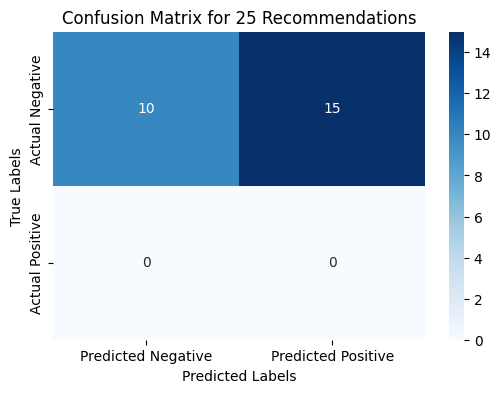

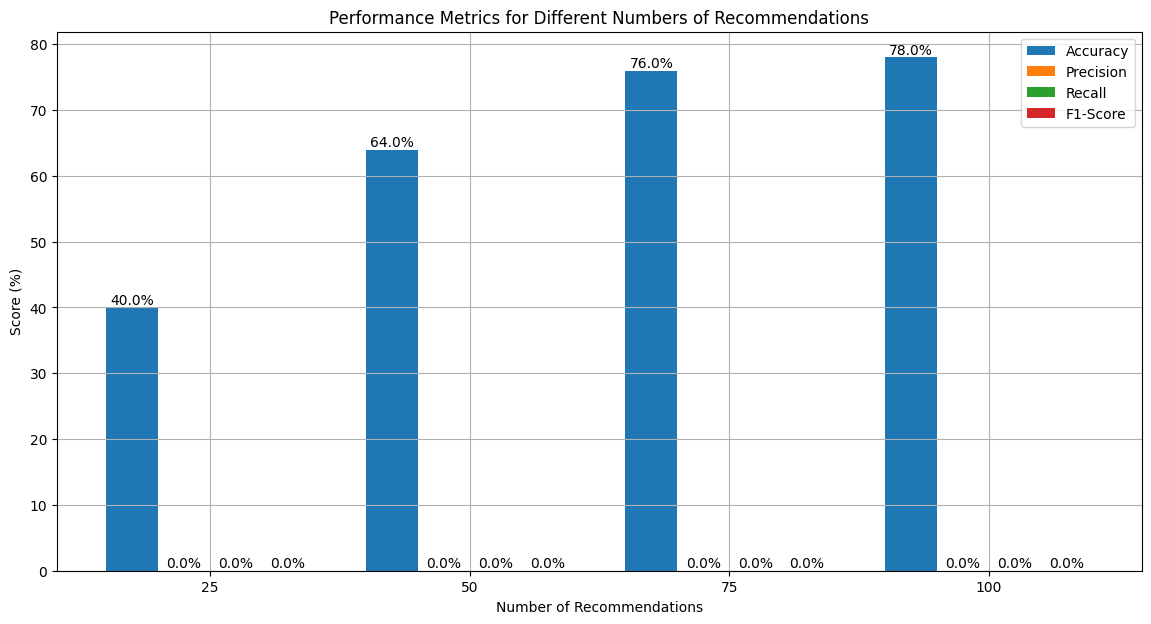

Performance Metrics Table:
   Number of Recommendations  Accuracy (%)  Precision (%)  Recall (%)  \
0                         25          40.0            0.0         0.0   
1                         50          64.0            0.0         0.0   
2                         75          76.0            0.0         0.0   
3                        100          78.0            0.0         0.0   

   F1-Score (%)  
0           0.0  
1           0.0  
2           0.0  
3           0.0  


In [81]:
from sklearn.metrics.pairwise import cosine_similarity  # Unused import
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import seaborn as sns
import numpy as np
import pandas as pd

# Function to find the ID and title based on an exact title match
def find_exact_title_match(title_query, df_id1):
    for idx, row in df_id1.iterrows():
        if row['title'].strip().lower() == title_query.strip().lower():
            return row['id'], row['original_title']  # Return the original title for display
    return None, None  # Return None if no exact match is found

# Function to calculate Jaccard similarity between two binary arrays
def jaccard_similarity(set_a, set_b):
    intersection = np.sum(np.minimum(set_a, set_b))
    union = np.sum(np.maximum(set_a, set_b))
    return intersection / union if union != 0 else 0

# Function to find and rerank similar texts using Jaccard similarity on binary embeddings
def find_and_rerank_similar_texts(user_query, top_n=5):
    user_embedding = vectorizer.transform([user_query]).toarray().squeeze()  # Ensure binary form if required
    similarities = []
    
    for idx, row in df_id.iterrows():
        combined_embedding = row['combined_embeddings']
        jaccard_sim = jaccard_similarity(user_embedding, combined_embedding)
        similarities.append((row['id'], row['original_title'], jaccard_sim))

    similarities.sort(key=lambda x: x[2], reverse=True)
    return similarities[:top_n]

# Function to recommend papers based on user input using Jaccard similarity
def recommend_articles(user_query, top_n=5):
    similar_texts = find_and_rerank_similar_texts(user_query, top_n)
    recommended_articles = [(id, original_title, score) for id, original_title, score in similar_texts]
    return recommended_articles

# Function to evaluate recommendations
def evaluate_recommendations(recommendations, ground_truth_df, input_id, threshold=0.2):
    y_true = []
    y_pred = []
    true_matches = []

    input_id_in_references = ground_truth_df[ground_truth_df['id'] == input_id]['references']
    for recommended_id, title, score in recommendations:
        is_relevant = False

        if not input_id_in_references.empty and recommended_id in input_id_in_references.values[0]:
            is_relevant = True
            true_matches.append(recommended_id)

        recommended_id_in_references = ground_truth_df[ground_truth_df['id'] == recommended_id]['references']
        if (not recommended_id_in_references.empty and input_id in recommended_id_in_references.values[0]):
            is_relevant = True
            true_matches.append(recommended_id)

        y_true.append(1 if is_relevant else 0)
        y_pred.append(1 if score > threshold else 0)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    conf_matrix = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel() if conf_matrix.size == 4 else (0, 0, 0, 0)

    return accuracy, precision, recall, f1, (tn, fp, fn, tp), conf_matrix

# Function to evaluate and store results for different numbers of recommendations
def evaluate_and_store_results(user_query, ground_truth_df, df_id1, recommendation_func):
    num_recommendations = [25, 50, 75, 100]
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    confusion_matrices = []
    tp_fps = []

    exact_match_id, _ = find_exact_title_match(user_query, df_id1)
    if exact_match_id is None:
        print(f"No exact title match found for '{user_query}' in df_id1\n")
        return num_recommendations, accuracies, precisions, recalls, f1_scores, confusion_matrices, tp_fps

    for n in num_recommendations:
        recommended_articles = recommendation_func(user_query, top_n=n)
        if recommended_articles:
            accuracy, precision, recall, f1, tp_fp, conf_matrix = evaluate_recommendations(recommended_articles, ground_truth_df, exact_match_id)
            accuracies.append(accuracy)
            precisions.append(precision)
            recalls.append(recall)
            f1_scores.append(f1)
            confusion_matrices.append(conf_matrix)
            tp_fps.append(tp_fp)

    return num_recommendations, accuracies, precisions, recalls, f1_scores, confusion_matrices, tp_fps

# Example usage
user_query = "LIBSVM: A library for support vector machines"#"Support-Vector Networks"
num_recommendations, accuracies, precisions, recalls, f1_scores, confusion_matrices, tp_fps = evaluate_and_store_results(user_query, df_references, df_id1, recommend_articles)

if accuracies:
    for i, n in enumerate(num_recommendations):
        print(f"Number of Recommendations: {n}")
        print(f"  Accuracy: {accuracies[i] * 100:.2f}%")
        print(f"  Precision: {precisions[i] * 100:.2f}%")
        print(f"  Recall: {recalls[i] * 100:.2f}%")
        print(f"  F1-Score: {f1_scores[i] * 100:.2f}%")
        tn, fp, fn, tp = tp_fps[i]
        print(f"  True Negatives: {tn}")
        print(f"  False Positives: {fp}")
        print(f"  False Negatives: {fn}")
        print(f"  True Positives: {tp}")
        print()

    # Plot confusion matrix for one set of recommendations (e.g., for 25 recommendations)
    tn, fp, fn, tp = tp_fps[0]
    conf_matrix = np.array([[tn, fp], [fn, tp]])

    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
    plt.title('Confusion Matrix for 25 Recommendations')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Create a clustered bar chart for Accuracy, Precision, Recall, F1-Score
    bar_width = 0.2
    indices = np.arange(len(num_recommendations))

    plt.figure(figsize=(14, 7))
    bars_accuracy = plt.bar(indices, [acc * 100 for acc in accuracies], bar_width, label='Accuracy')
    bars_precision = plt.bar(indices + bar_width, [prec * 100 for prec in precisions], bar_width, label='Precision')
    bars_recall = plt.bar(indices + 2 * bar_width, [rec * 100 for rec in recalls], bar_width, label='Recall')
    bars_f1 = plt.bar(indices + 3 * bar_width, [f1 * 100 for f1 in f1_scores], bar_width, label='F1-Score')

    plt.xlabel('Number of Recommendations')
    plt.ylabel('Score (%)')
    plt.title('Performance Metrics for Different Numbers of Recommendations')
    plt.xticks(indices + 1.5 * bar_width, num_recommendations)

    def add_text_annotations(bars):
        for bar in bars:
            height = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width() / 2.0,
                height,
                f'{height:.1f}%',
                ha='center',
                va='bottom'
            )

    add_text_annotations(bars_accuracy)
    add_text_annotations(bars_precision)
    add_text_annotations(bars_recall)
    add_text_annotations(bars_f1)

    plt.legend()
    plt.grid(True)
    plt.show()

    # Create and display a table of the results
    results_df = pd.DataFrame({
        'Number of Recommendations': num_recommendations,
        'Accuracy (%)': [acc * 100 for acc in accuracies],
        'Precision (%)': [prec * 100 for prec in precisions],
        'Recall (%)': [rec * 100 for rec in recalls],
        'F1-Score (%)': [f1 * 100 for f1 in f1_scores]
    })

    print("Performance Metrics Table:")
    print(results_df)
else:
    print("No recommendations evaluated.")


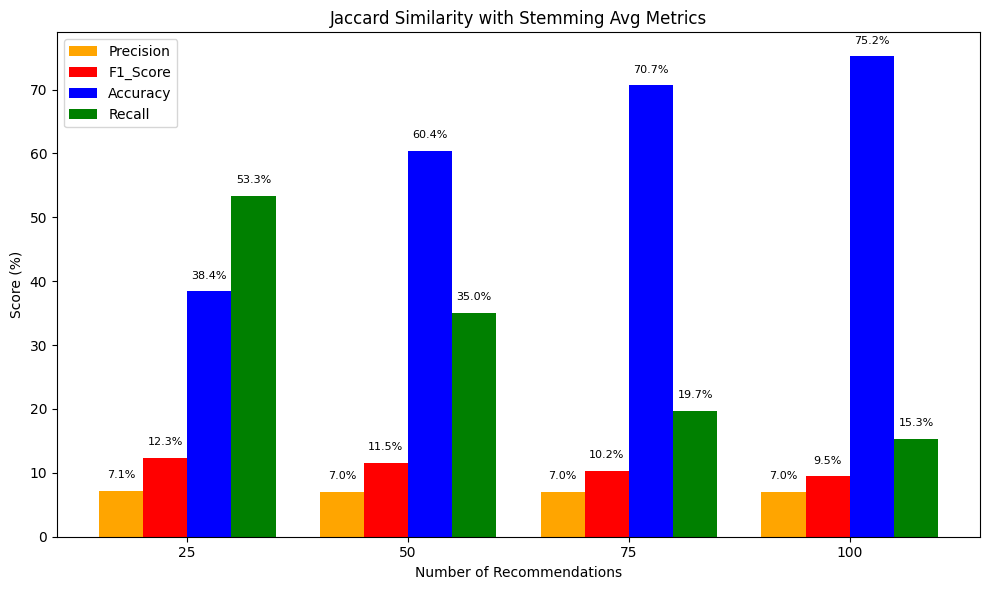

In [1]:
import matplotlib.pyplot as plt
import numpy as np
results = {
    'Recommendations': [25, 50, 75, 100],
    'Accuracy': [
        [16.0, 40.0, 52.0, 44.0, 40.0],  # values for recommendation 25 across tables
        [34.0, 64.0, 70.0, 70.0, 64.0],  # values for recommendation 50 across tables
        [48.0, 74.67, 78.67, 76.0, 76.0],  # values for recommendation 75 across tables
        [58.0, 80.0, 81.0, 79.0, 78.0]   # values for recommendation 100 across tables
    ],
    'Precision': [
        [16.0, 6.25, 0.0, 13.33, 0.0],  # values for recommendation 25 across tables
        [15.38, 6.25, 0.0, 13.33, 0.0],  # values for recommendation 50 across tables
        [15.38, 6.25, 0.0, 13.33, 0.0],  # values for recommendation 75 across tables
        [15.38, 6.25, 0.0, 13.33, 0.0]   # values for recommendation 100 across tables
    ],
    'Recall': [
        [100.0, 100.0, 0.0, 66.67, 0.0],  # values for recommendation 25 across tables
        [100.0, 25.0, 0.0, 50.0, 0.0],    # values for recommendation 50 across tables
        [50.0, 20.0, 0.0, 28.57, 0.0],    # values for recommendation 75 across tables
        [40.0, 16.67, 0.0, 20.0, 0.0]     # values for recommendation 100 across tables
    ],
    'F1_Score': [
        [27.59, 11.76, 0.0, 22.22, 0.0],  # values for recommendation 25 across tables
        [26.67, 10.0, 0.0, 21.05, 0.0],   # values for recommendation 50 across tables
        [23.53, 9.52, 0.0, 18.18, 0.0],   # values for recommendation 75 across tables
        [22.22, 9.09, 0.0, 16.0, 0.0]     # values for recommendation 100 across tables
    ]
}

averaged_results = {metric: [np.mean(values) for values in metrics] for metric, metrics in results.items() if metric != 'Recommendations'}

# Define colors for each metric in the fixed order
metrics_order = ['Precision', 'F1_Score','Accuracy', 'Recall']
colors = {'Accuracy': 'blue', 'Precision': 'orange', 'Recall': 'green', 'F1_Score': 'red'}

# Plotting the bars in a fixed order for each recommendation level
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(results['Recommendations']))
width = 0.2  # Width of each bar

# Plot bars for each recommendation level
for i, rec in enumerate(results['Recommendations']):
    for j, metric in enumerate(metrics_order):
        value = averaged_results[metric][i]
        ax.bar(x[i] + j * width, value, width, label=metric if i == 0 else "", color=colors[metric])

        # Add percentage labels on top of each bar
        ax.text(x[i] + j * width, value + 2, f"{value:.1f}%", ha='center', fontsize=8)

# Set the x-axis labels and title
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(results['Recommendations'])
ax.set_xlabel("Number of Recommendations")
ax.set_ylabel("Score (%)")
ax.set_title("Jaccard Similarity with Stemming Avg Metrics")
ax.legend()

plt.tight_layout()
plt.show()
